# Fitting HSC data in multiband mode using MultiProFit

In [1]:
import os
from astropy.io.ascii import Csv
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.visualization as apvis
from astropy.wcs import WCS
import galsim as gs
import gauss2d as g2
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprofit.fitutils as mpffit
import multiprofit.objects as mpfobj
import numpy as np

mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.dpi'] = 120

In [2]:
# Define model specs
modelspecs = mpffit.get_modelspecs('modelspecs-mg8-base-psfg2.csv')

In [3]:
# Define settings
band_ref = 'i'
bands = {'i': 0.87108833, 'r': 0.97288654, 'g': 1.44564678}
band_multi = ''.join(bands)

# This is in the WCS, but may as well keep full precision
scale_pixel_hsc = 0.168

# Common to all FITS
hdu_img, hdu_mask, hdu_var = 1, 2, 3
maskbits = tuple(f'MP_{b}' for b in ('BAD', 'SAT', 'INTRP', 'CR', 'EDGE', 'CLIPPED', 'NO_DATA', 'CROSSTALK',
                                     'NO_DATA', 'UNMASKEDNAN', 'SUSPECT', 'REJECTED', 'SENSOR_EDGE'))

In [4]:
# Acquired from https://hsc-release.mtk.nao.ac.jp/datasearch with query:
# SELECT
# object_id, ra, dec,
# pdr3_wide.forced.g_cmodel_mag, pdr3_wide.forced.g_cmodel_magerr,
# pdr3_wide.forced.r_cmodel_mag, pdr3_wide.forced.r_cmodel_magerr,
# pdr3_wide.forced.i_cmodel_mag, pdr3_wide.forced.i_cmodel_magerr,
# pdr3_wide.forced2.r_psfflux_mag, pdr3_wide.forced2.r_psfflux_magerr,
# r_cmodel_ellipse_11, r_cmodel_ellipse_22
# FROM pdr3_wide.forced
# LEFT JOIN pdr3_wide.forced2 USING (object_id)
# LEFT JOIN pdr3_wide.meas USING (object_id)
# WHERE isprimary AND conesearch(coord, 149.2558, 2.5652, 28.5)
# AND pdr3_wide.forced2.r_psfflux_mag < 26;
cat = Csv().read('multiprofit_hsc_wide_cluster_easy_sources.csv')
prefix = '149.2558,2.5652_'

# Read data, acquired with:
# https://github.com/taranu/astro_imaging/blob/4d5a8e095e6a3944f1fbc19318b1dbc22b22d9ca/examples/HSC.ipynb
# (with get_mask=True, get_variance=True,) and ra, dec = '149.2558', '2.5652'
images, psfs = {}, {}
for band in bands:
    images[band] = fits.open(f'{prefix}300x300_{band}.fits')
    psfs[band] = fits.open(f'{prefix}{band}_psf.fits')

wcs = WCS(images[band_ref][hdu_img])
cat['x'], cat['y'] = wcs.world_to_pixel(SkyCoord(cat['ra'], cat['dec'], unit='deg'))

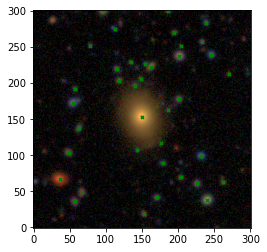

In [5]:
# Plot image
img_rgb = apvis.make_lupton_rgb(*[img[1].data*bands[band] for band, img in images.items()], stretch=0.2, Q=12)
plt.scatter(cat['x'], cat['y'], s=10, c='g', marker='x')
plt.imshow(img_rgb)
# plt.show()

240.14343086763438 38.56301374600753 7.3599368394444955
Masking src=(240.14343086763438, 38.56301374600753) dist=143.40792721933764
149.3399492287681 153.28591650608814 22.832404721297813
66.80784082339414 48.89690206357318 11.803834825243557
Masking src=(66.80784082339414, 48.89690206357318) dist=131.6342167444372
200.95577330227934 177.51401688522765 6.251159407768013
Masking src=(200.95577330227934, 177.51401688522765) dist=57.232352457385225
54.6134103425029 172.51628945235825 9.446756171743152
Masking src=(54.6134103425029, 172.51628945235825) dist=98.38168059855072
170.75904121230087 41.62937589981266 4.409536966933728
Masking src=(170.75904121230087, 41.62937589981266) dist=110.7395211422101
96.52616647185823 300.44456965561403 7.454931211100804
Masking src=(96.52616647185823, 300.44456965561403) dist=159.3629463675005
56.97082259239505 36.125966628159404 11.291040221596694
Masking src=(56.97082259239505, 36.125966628159404) dist=147.74683257615422
201.709180583317 237.302555682

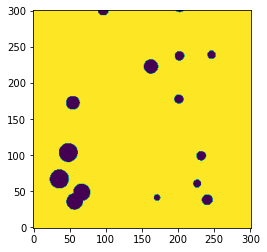

In [6]:
# Generate a rough mask around other sources
bright = cat['i_cmodel_mag'] < 24
# Mask out a radius of twice r_eff
radii = 3*np.sqrt(cat['r_cmodel_ellipse_11'] + cat['r_cmodel_ellipse_22'])/scale_pixel_hsc
radii[~np.isfinite(radii)] = 0
radii[radii < 3] = 3
radii[radii > 30] = 30
cat['r'] = radii

img_ref = images[band_ref][hdu_img].data

mask_inverse = np.ones(img_ref.shape, dtype=bool)
y_cen, x_cen = (x/2. for x in img_ref.shape)
y, x = np.indices(img_ref.shape)

# Can add extra sources if needed
sources = (cat[bright], ) #{'x': 257.5, 'y': 247.9, 'r': 5},)

for srcs in sources:
    for src in srcs:
        x_src, y_src, r_src = src['x'], src['y'], src['r']
        print(x_src, y_src, r_src)
        dist = np.hypot(x_src - x_cen, y_src - y_cen)
        if dist > 5:
            print(f'Masking src=({x_src}, {y_src}) dist={dist}')
            dist = np.hypot(y - y_src, x - x_src)
            mask_inverse[dist < r_src] = 0

plt.imshow(mask_inverse)

In [7]:
# Setup exposure with band-specific image, mask and variance
exposures_psfs = []
for band in bands:
    data = images[band]
    # There are better ways to use bitmasks, but this will do
    header = data[hdu_mask].header
    bitmask = data[hdu_mask].data
    mask = np.zeros_like(bitmask, dtype='bool')
    for bit in maskbits:
        mask |= ((bitmask & 2**header[bit]) != 0)
        
    mask = (mask == 0) & mask_inverse
    variance_inv = 1.0/data[hdu_var].data
    variance_inv[mask != 1] = 0
    
    exposures_psfs.append(
        (
            mpfobj.Exposure(
                band,
                g2.ImageD(data[hdu_img].data),
                error_inverse=g2.ImageD(variance_inv),
                mask_inverse=g2.ImageB(mask),
                is_error_sigma=False,
            ),
            gs.InterpolatedImage(gs.Image(psfs[band][0].data, scale=scale_pixel_hsc))
        )
    )

In [8]:
#
print(exposures_psfs[0][0].psf)

None


In [9]:
# Fit in each band separately
results = {}
for band in bands:
    print(f"Fitting in band={band}")
    results[band] = mpffit.fit_galaxy_exposures(exposures_psfs, [band], modelspecs=modelspecs)

Fitting in band=i
Fitting in band=r
Fitting in band=g


In [10]:
# A rather hacky way to recast the results of single-band fits into what the multi-band version would have returned
# This would break if we were multifitting multiple exposures per band, for example
results_psfs = {'psfs': {idx: results[band]['psfs'][idx] for idx, band in enumerate(bands)}}
# Do the multi-band fit using the single-band parameters as initial params
# (this uses structural parameters from either a single reference band or some weighted average)
results[band_multi] = mpffit.fit_galaxy_exposures(exposures_psfs, bands, modelspecs=modelspecs, results=results_psfs)

In [11]:
# Print model LLs and fitting time
for fittype, resultfull in results.items():
    fits_mpf = resultfull['fits']['galsim']
    for model, result in fits_mpf.items():
        print(fittype, model, -result.fits[-1]['result'].cost, np.sum([x['time'] for x in result.fits]))

i mg8sermpx -67996.82514155639 3.0788002014160156
i mg8devexptpx -61483.24551861803 10.941551685333252
i mg8devexp2px -38774.41277811906 5.8712005615234375
i mg8serserbpx -38332.60831741371 5.186274766921997
r mg8sermpx -77495.75505401142 3.6804440021514893
r mg8devexptpx -40948.36782340411 10.83678126335144
r mg8devexp2px -39894.44076948925 5.11414909362793
r mg8serserbpx -39743.22343463091 5.295393705368042
g mg8sermpx -52201.84761891618 3.1213090419769287
g mg8devexptpx -41501.85060529096 9.664209365844727
g mg8devexp2px -38627.20790443408 7.172958850860596
g mg8serserbpx -38300.4035596329 5.2533111572265625
irg mg8sermpx -244153.8347218071 11.086684226989746
irg mg8devexptpx -178448.98496206314 32.73844528198242
irg mg8devexp2px -123725.95538879461 16.9081814289093
irg mg8serserbpx -120806.56221458163 17.141368627548218


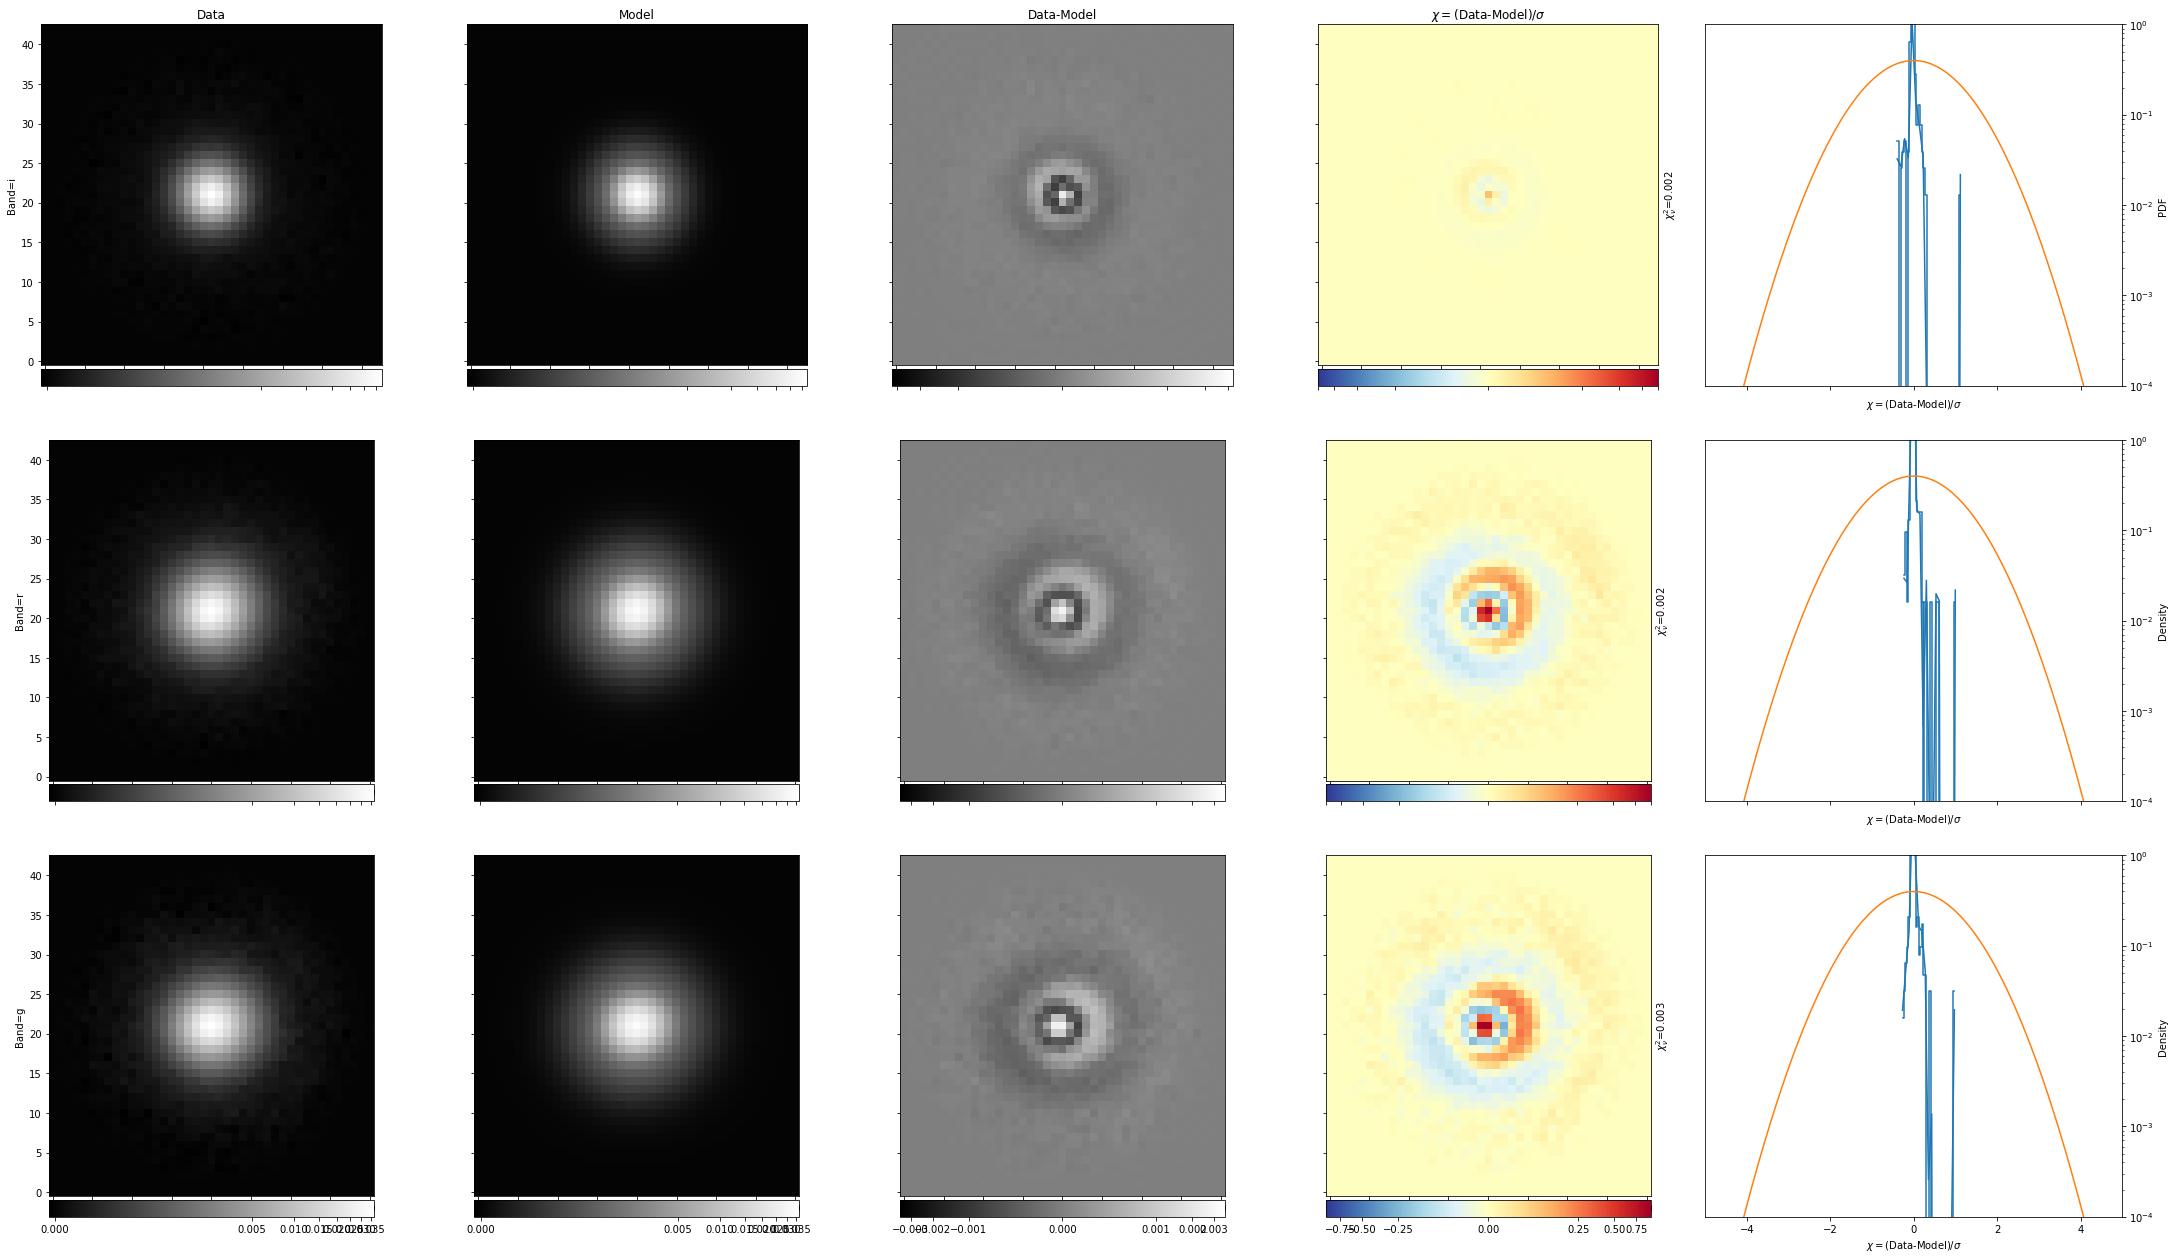

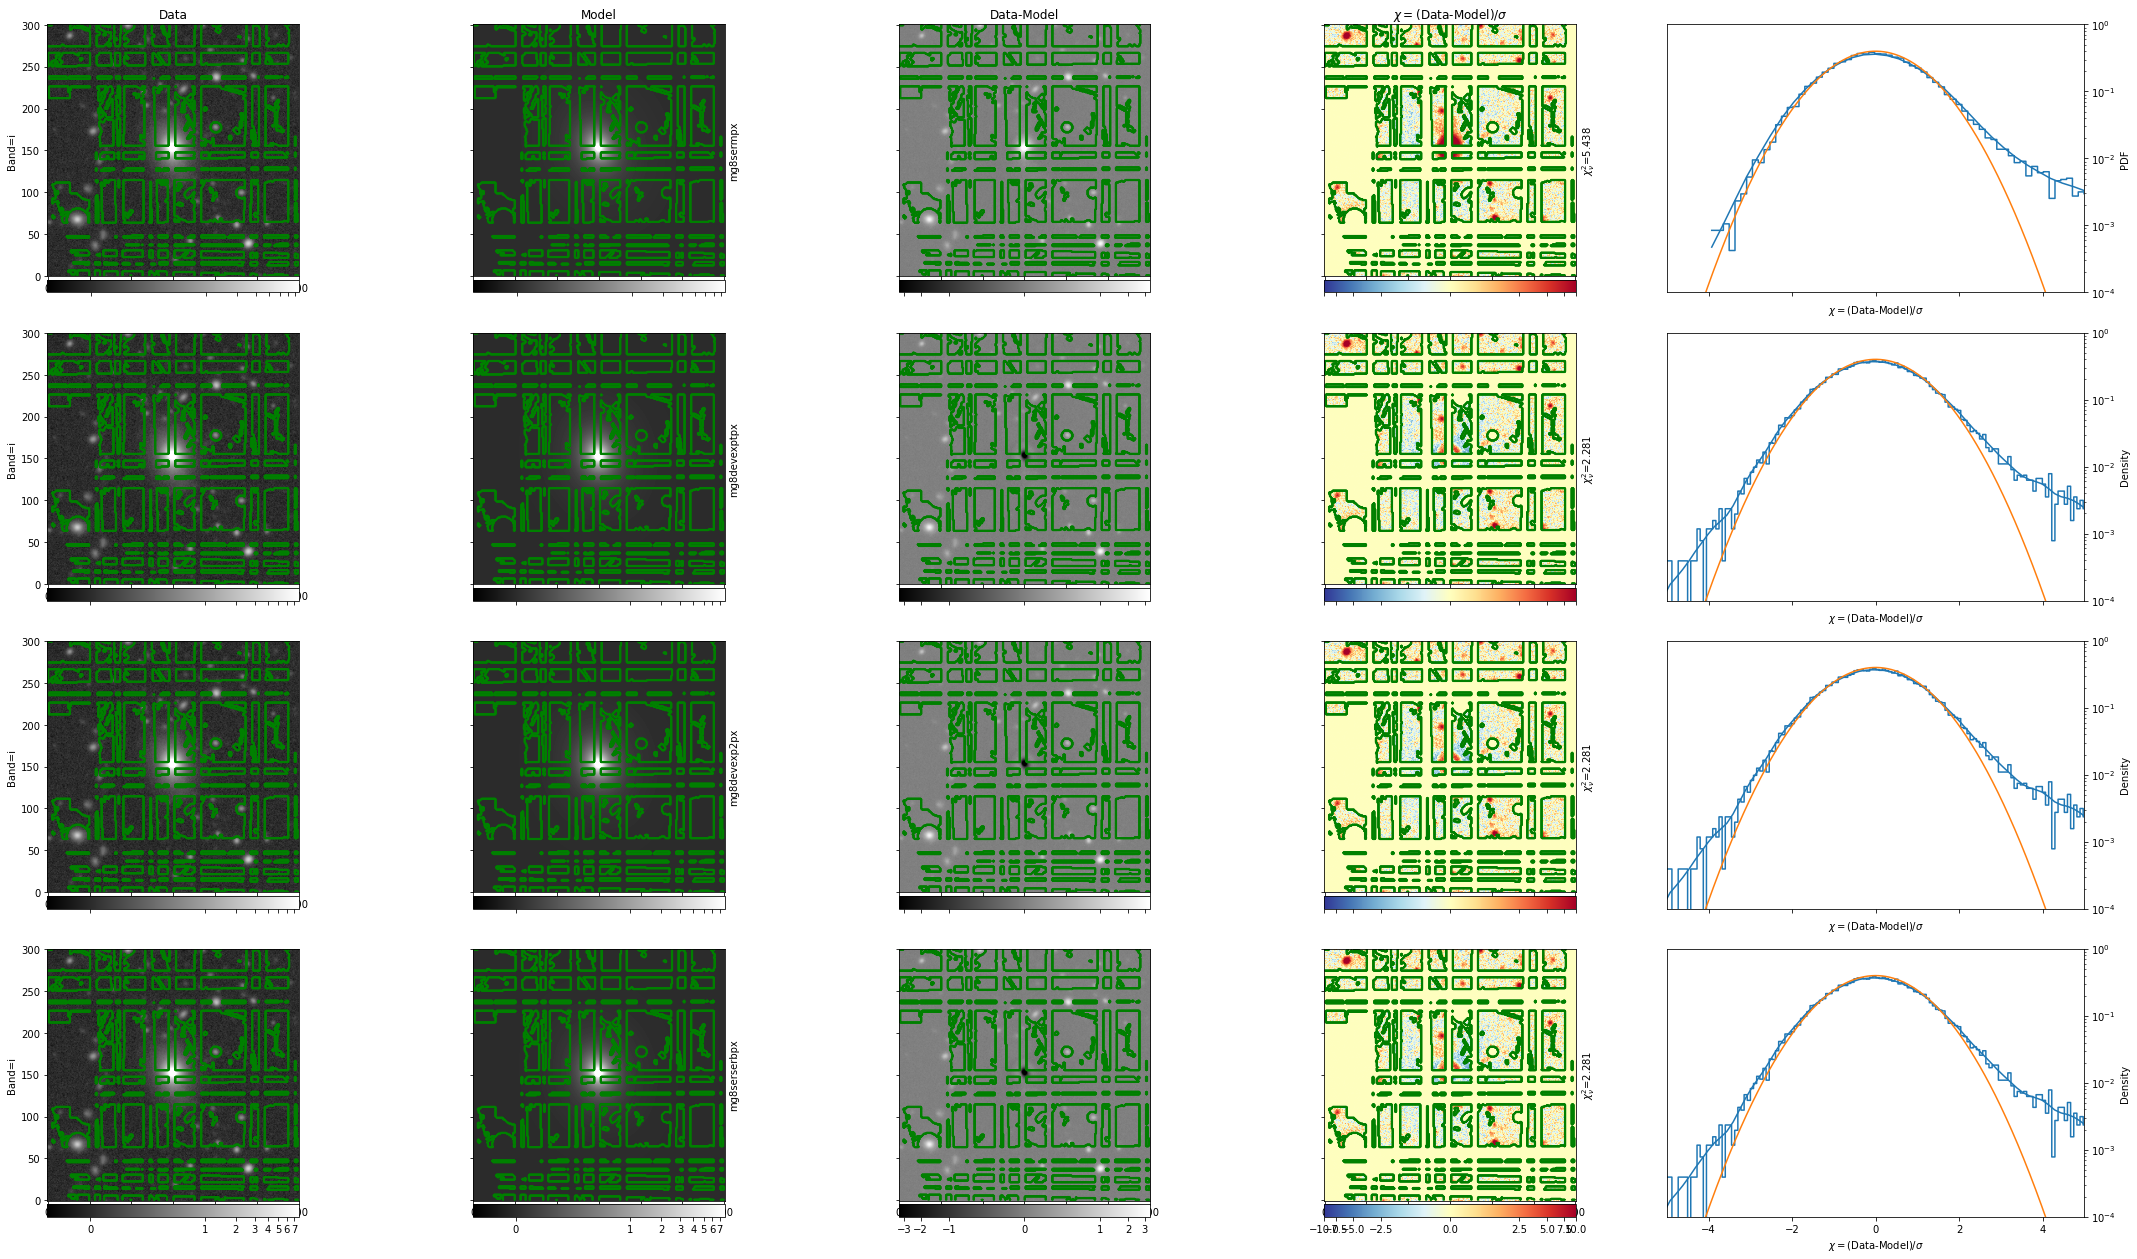

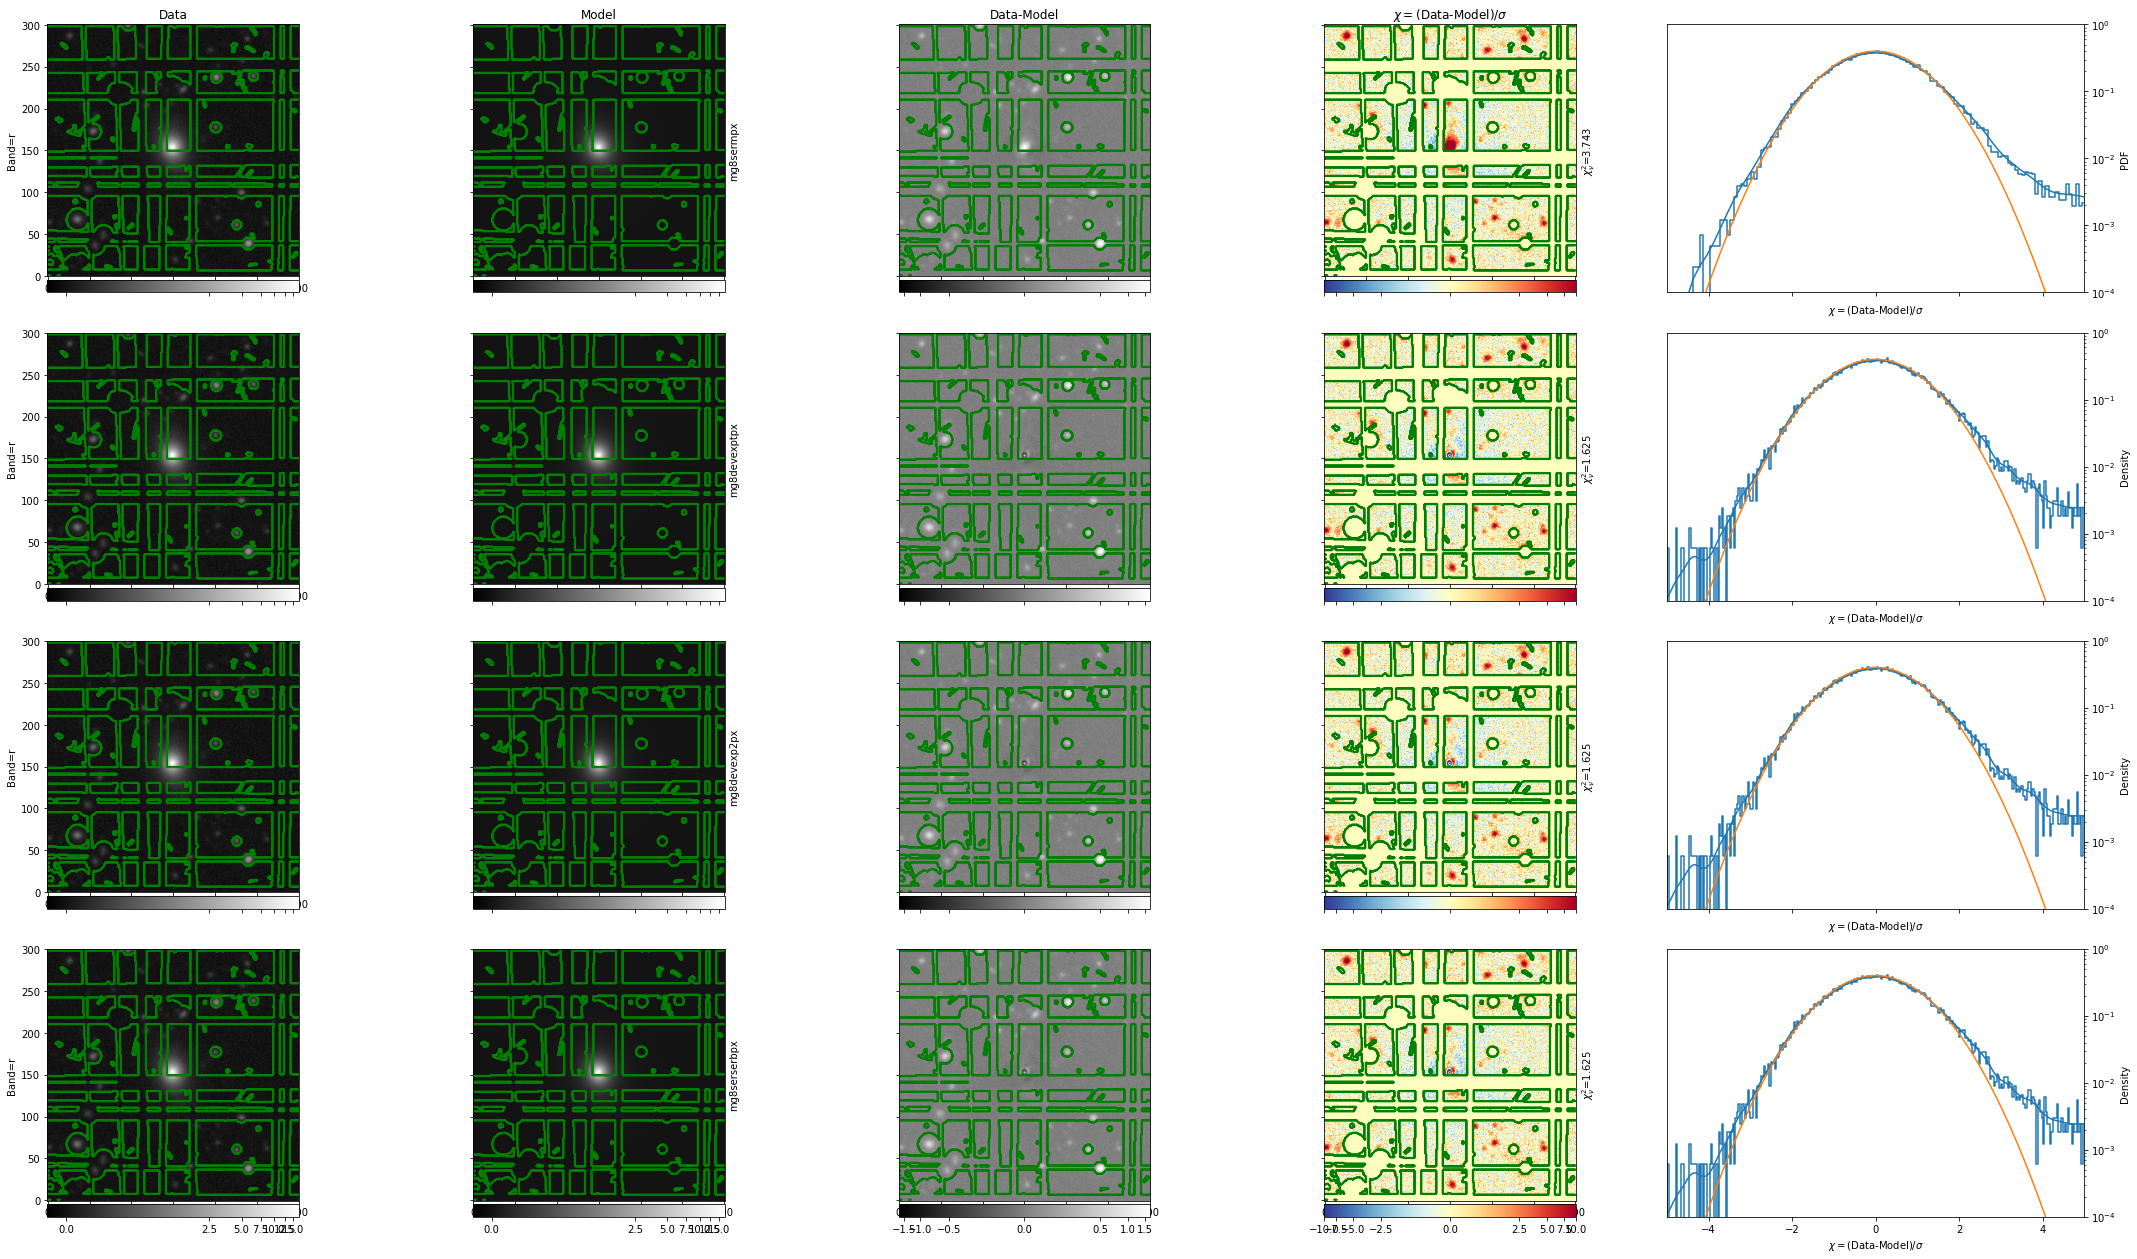

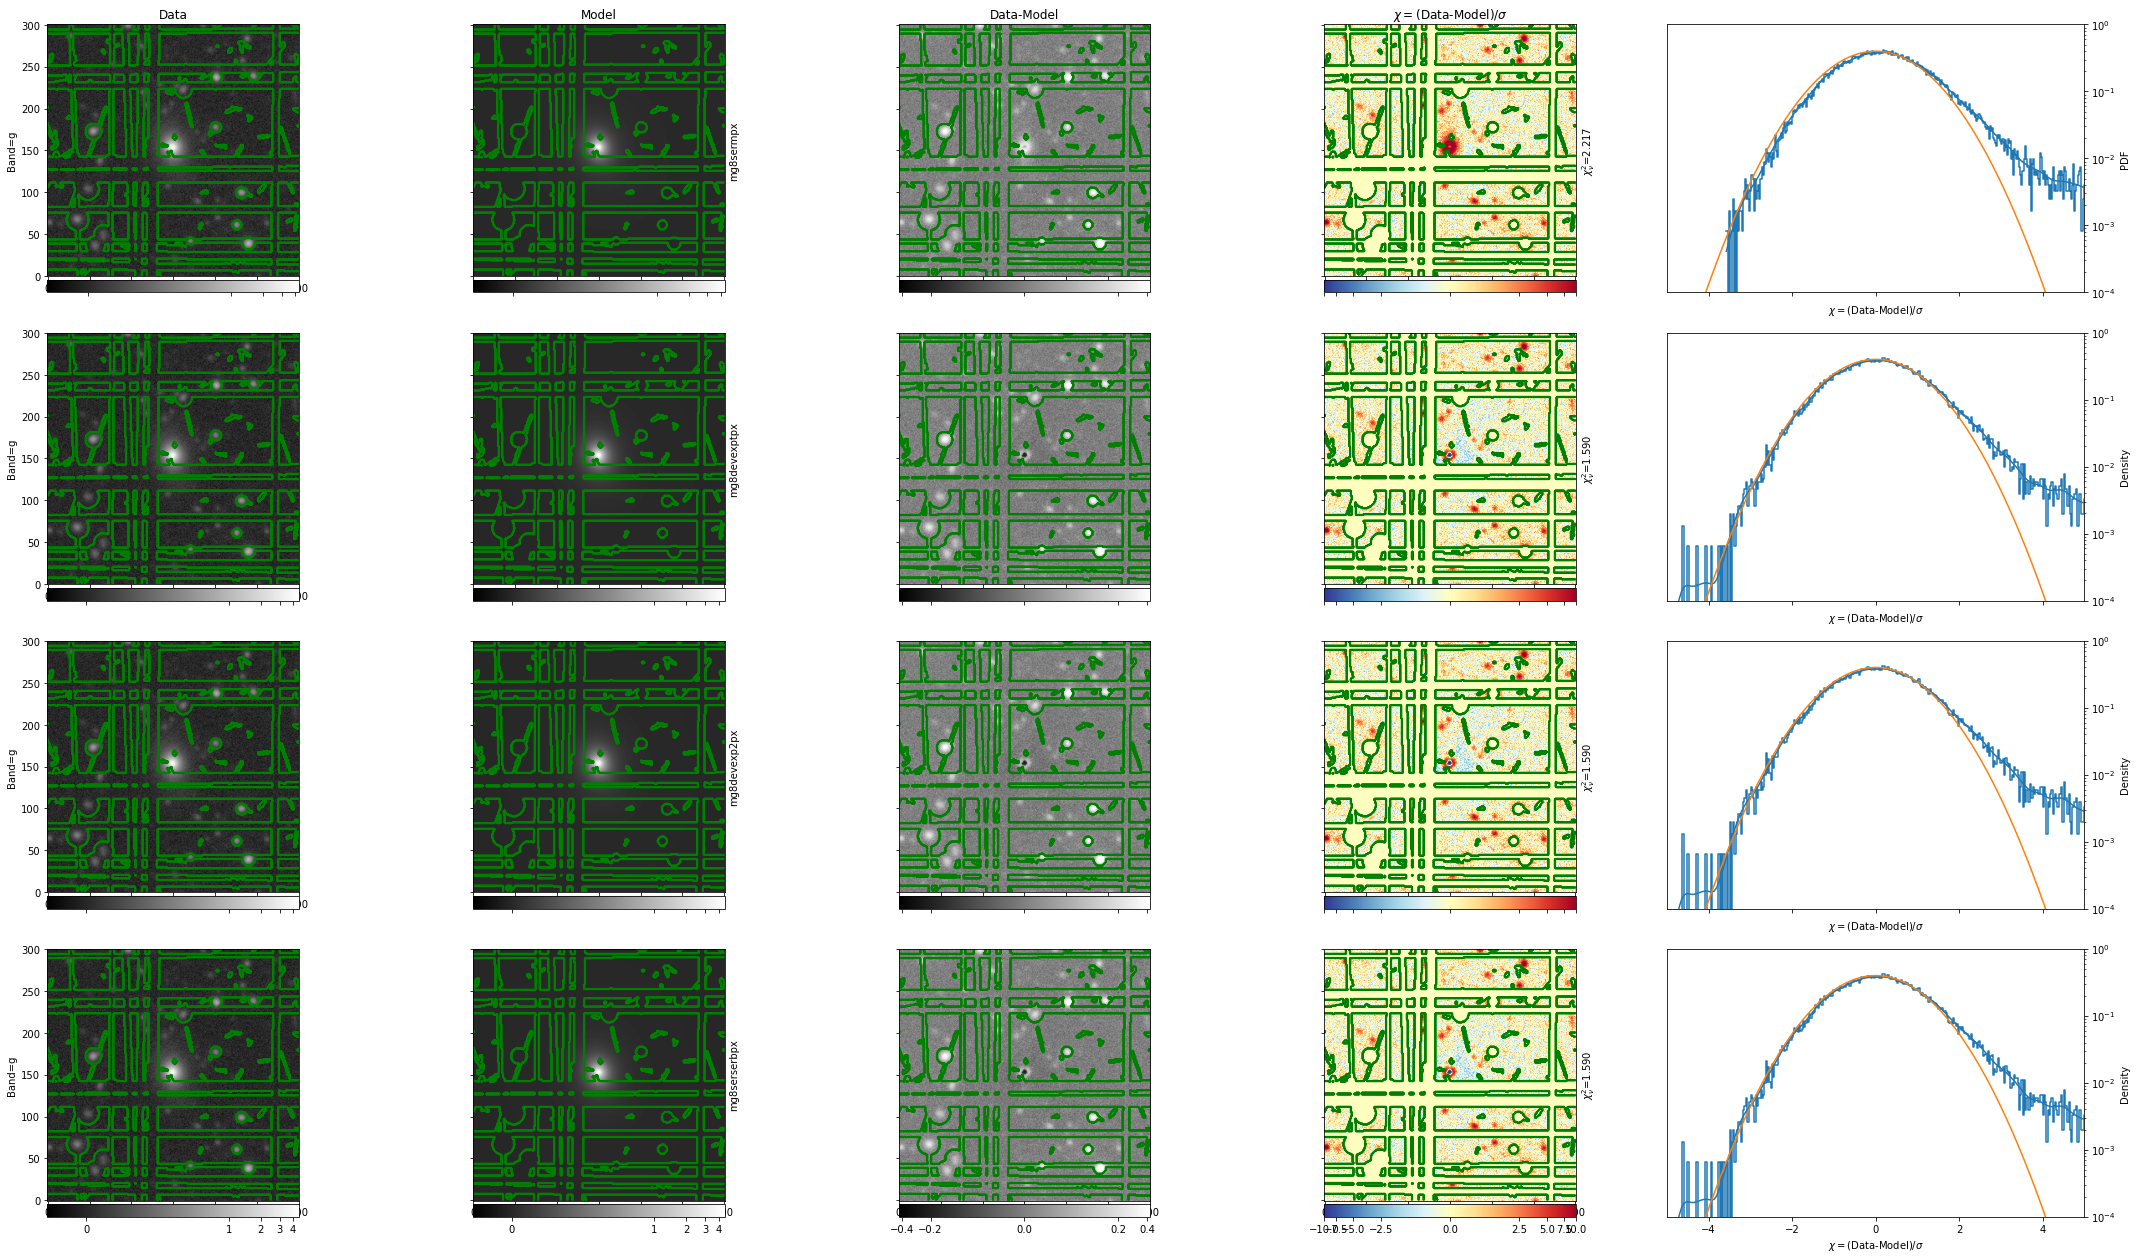

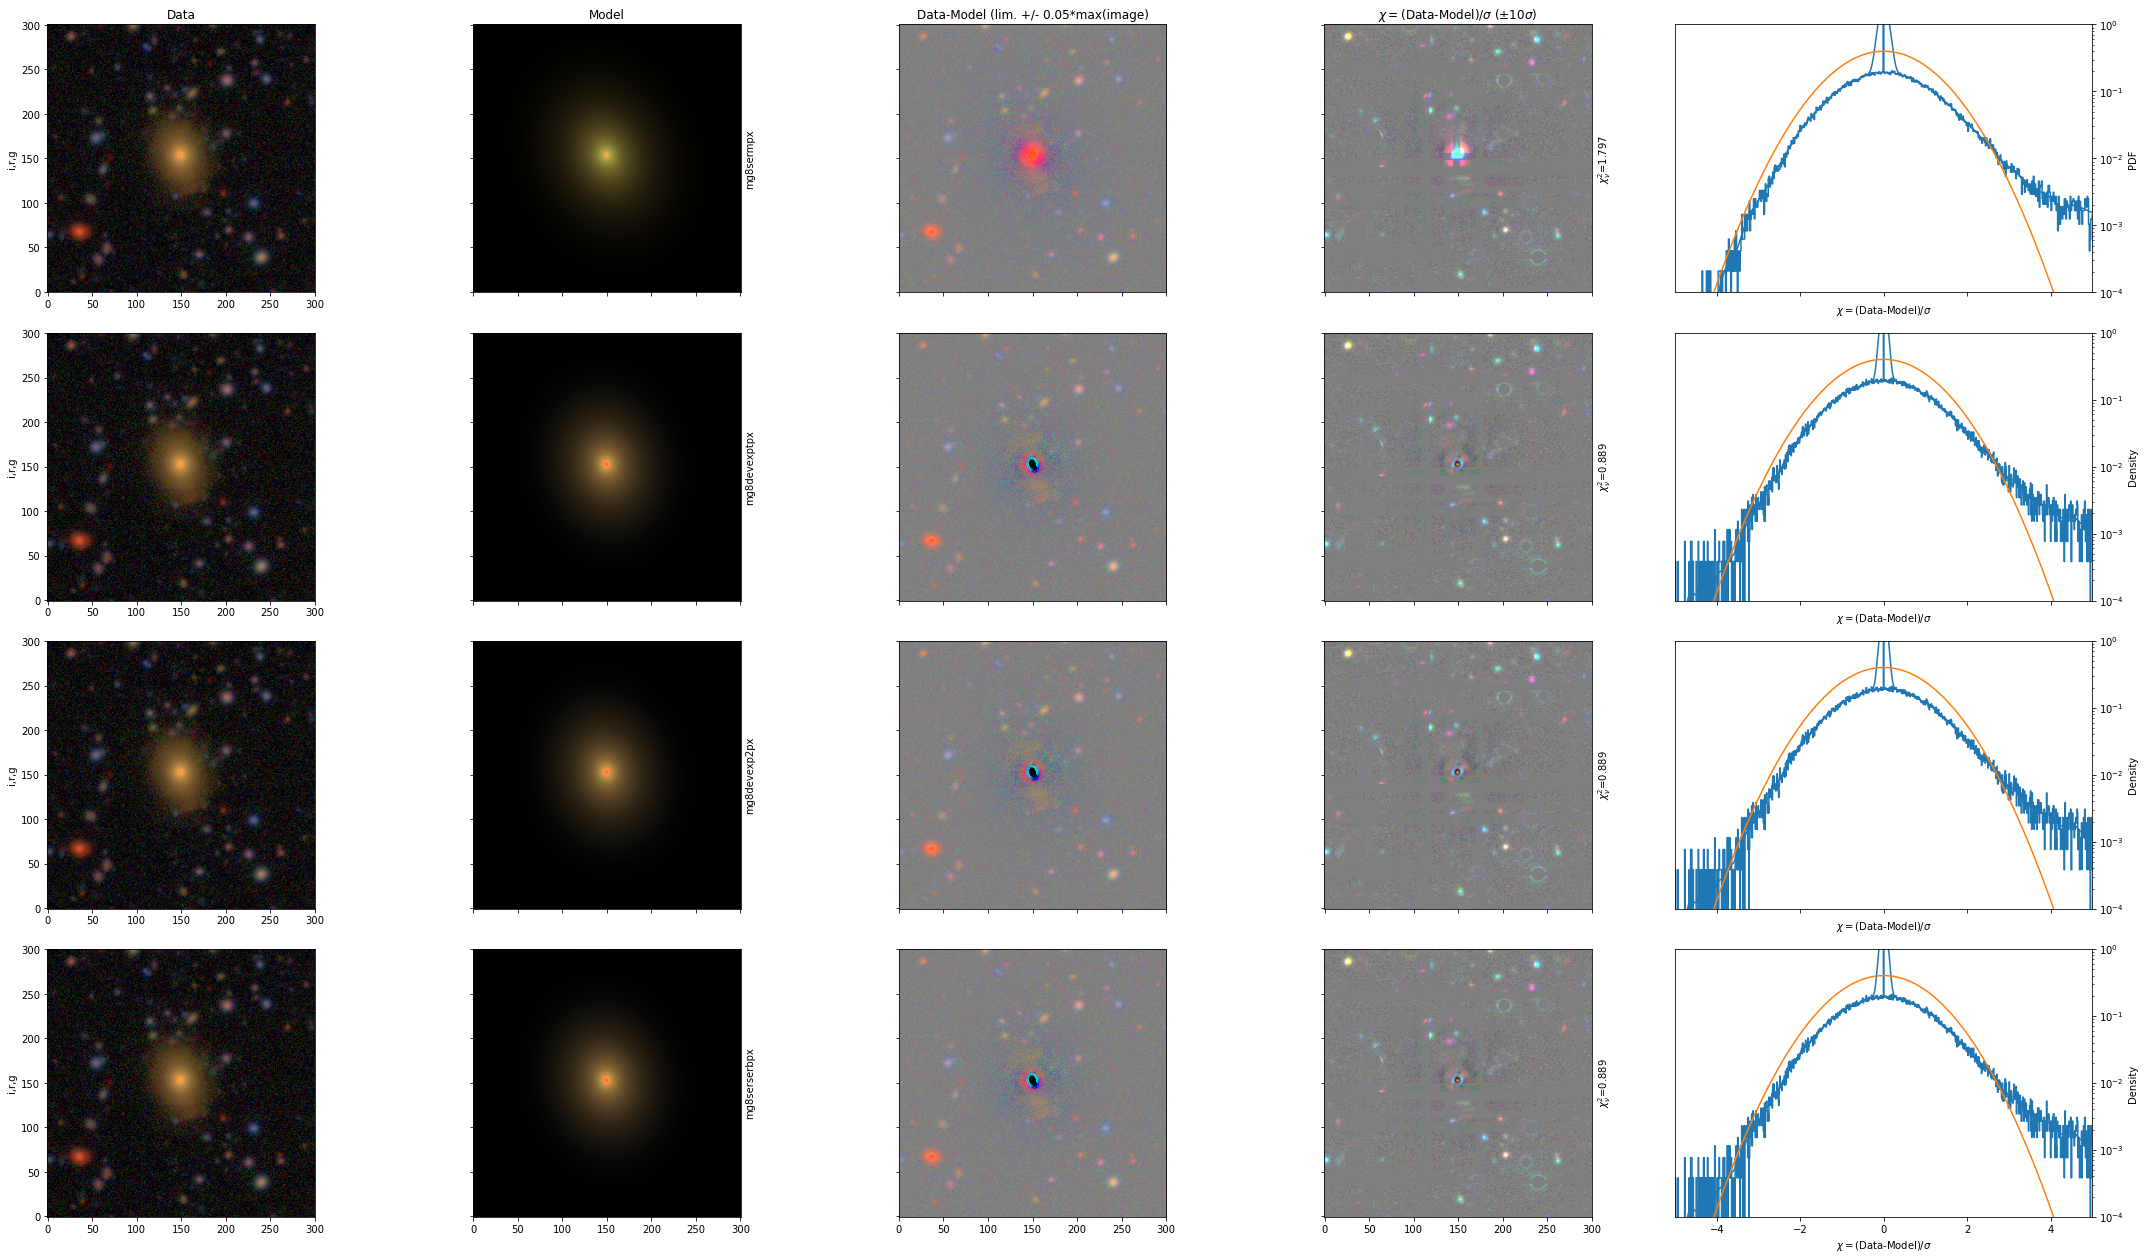

In [12]:
# Plot every model fit
figuresize = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = [32.0, 18.0]
_ = mpffit.fit_galaxy_exposures(
    exposures_psfs, bands, modelspecs=modelspecs, results=results[band_multi], redo=False, plot=True,
    img_plot_maxs=[40., 20., 10.], img_multi_plot_max=2,
    weights_band=bands,
)
plt.show();
mpl.rcParams['figure.figsize'] = figuresize

In [13]:
#
print(results[band_multi])

{'fits': {'galsim': {'mg8sermpx': ModelFits(fits=[{'fitinfo': {'log': [{'params': array([ 1.50970941e+02,  1.51120838e+02,  1.76367915e+00,  1.80183946e+00,
       -7.51988821e-03,  2.93537421e+00,  3.15263566e+00,  2.80046547e+00,
       -6.31173481e+00]), 'likelihood': -5797712.351723579, 'prior': 0.0}, {'params': None, 'likelihood': -5651368.462534856, 'prior': 0.0}, {'params': array([ 1.50970941e+02,  1.51120838e+02,  1.76367915e+00,  1.80183946e+00,
       -7.51988821e-03,  3.45845264e+00,  3.47675104e+00,  3.12327683e+00,
       -6.31173481e+00]), 'likelihood': None, 'prior': None}, {'params': array([ 1.48958005e+02,  1.48747382e+02,  1.52275285e+00,  1.56122600e+00,
       -9.86138252e-02,  3.24475424e+00,  3.26449613e+00,  2.89857905e+00,
        2.56553238e+00]), 'likelihood': None, 'prior': None}, {'params': array([ 1.52198714e+02,  1.64806282e+02,  1.41912298e+00,  1.55910777e+00,
       -1.16828727e-01,  3.39766784e+00,  3.31910929e+00,  2.89142551e+00,
        4.87138556e+